# Disapearing forests - Milestone 2.

## Data preprocessing
The initial preprocessing of the data was using __Shell__. The script used for preprocessing the normalized datasets from __FAOSTAT__ can be found in `data/faostat/clean_me.sh`.

In [1]:
# all the necessary imports
import pandas as pd


In [146]:
# FAOSTAT are are split into multiple groups, FAOSTAT_countries consists from names of the countries
# and FAOSTAT_country_groups consists from bigger areas, such as (Europe, Americas, East Europe etc.)
FAOSTAT_country_data = pd.read_csv("data/faostat/FAOSTAT_countries.csv", engine='python')
FAOSTAT_country_groups = FAOSTAT_country_data["Country Group"].unique()
FAOSTAT_countries = FAOSTAT_country_data["Country"].unique()
CONTINENTS = ['Africa', 'Asia', 'Australia and New Zealand', 'Europe', 'Northern America', 'South America']


## The deforestation trend
At first, we have investifated the trend of deforestation over the time in each country available in our dataset.

### Inputs_LandUse_E_All_Data_cleared.csv

In [7]:
# select tree areas from Inputs_LandUse 
LAND_USE_FOREST_ITEMS = ['Forestry', 'Forest land', 'Primary Forest','Other naturally regenerated forest', 'Planted Forest']

land_use_all = pd.read_csv("data/faostat/Inputs_LandUse_E_All_Data_cleared.csv", engine='python')
land_use = land_use_all[land_use_all.Item.isin(LAND_USE_FOREST_ITEMS) &
                        land_use_all.Element.str.match('Area')]


In [52]:
# foreseted areas (ha) for every contry per year
forested_area_yearly = land_use[land_use.Area.isin(FAOSTAT_countries)].groupby(["Area", "Year"]).Value.sum()
forested_area_yearly = forested_area_yearly.unstack("Year")


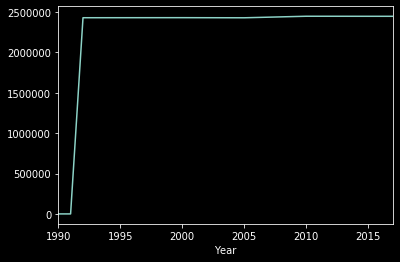

In [168]:
# plot forested area in Brazil over years
forested_area_yearly.loc['Brazil'].plot()


In [14]:
# forested areas in continents over yers
continents_forests_area = land_use_all[land_use_all.Item.isin(LAND_USE_FOREST_ITEMS) &   
                                       land_use_all.Element.str.match('Area') & 
                                       land_use.Area.isin(CONTINENTS)].groupby(["Area", "Year"]).Value.sum()

continents_forests_area = continents_forests_area.unstack("Year")


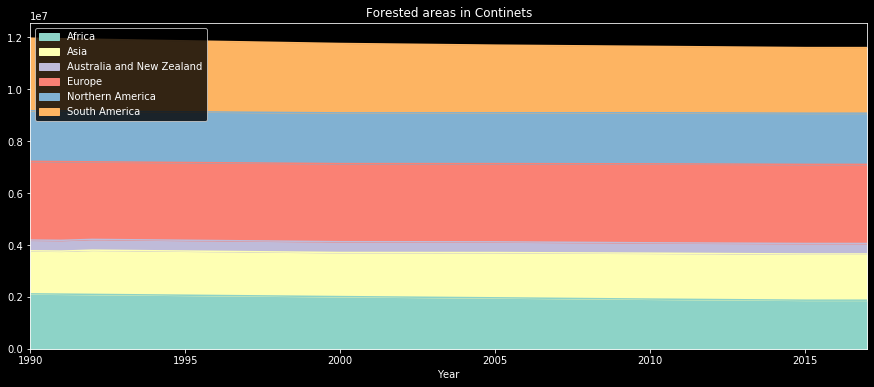

In [36]:
# plot forested areas in continents over years
continetns_forests_plot = continents_forests_area.T.plot.area(figsize=(15,6), title="Forested areas in Continets")
continetns_forests_plot.legend(loc='upper left')


In [81]:
# fill missing values in the forested_area_yearly (contry per year areas) by the most left valid value
forested_area_yearly = forested_area_yearly.fillna(method="backfill")


In [136]:
# The 20 countries which have deforestated most of forested areas over the years
forested_areas_diff = forested_area_yearly.iloc[:, 0] - forested_area_yearly.iloc[:, -1]
forested_areas_diff = forested_areas_diff.sort_values(ascending=False)
forested_areas_diff[:20]

Area
USSR                                2542048.800
Brazil                               159501.000
Indonesia                             82605.000
Kyrgyzstan                            50983.700
Ethiopia PDR                          50205.000
Sudan (former)                        46185.939
Luxembourg                            40815.900
Tajikistan                            40779.000
Micronesia (Federated States of)      37415.205
Northern Mariana Islands              36307.512
Bosnia and Herzegovina                34599.000
Sudan                                 34552.125
Lithuania                             34536.000
North Macedonia                       33402.000
Nigeria                               30723.000
Myanmar                               30531.000
United Republic of Tanzania           29580.000
Georgia                               25432.800
Zimbabwe                              24306.000
Bolivia (Plurinational State of)      24093.000
dtype: float64

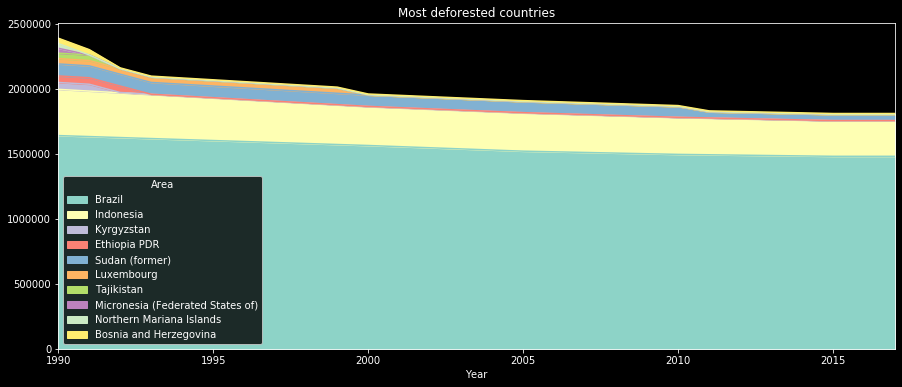

In [144]:
#The 10 countries which have deforestated most of forested areas over the years (without USSR)
# USSR stoped existing so the value has droped rapidly after dissolution od Soviet Union
forested_area_yearly.loc[forested_areas_diff[1:11].index].T.plot.area(figsize=(15,6), title="Most deforested countries")


In [167]:
# The 20 countries with biggest expansion of forests
forested_areas_diff[-20:]
# Russian Federation seems as an Outlier

Area
Iran (Islamic Republic of)      -4847.766
Italy                           -5121.000
Estonia                         -5280.000
Turkey                          -6279.000
Thailand                        -7182.000
Chile                           -7416.000
France                          -7659.000
Serbia                          -8038.002
Uzbekistan                      -8339.700
Latvia                          -9675.000
Turkmenistan                   -12277.800
Spain                          -13825.140
Viet Nam                       -16230.000
India                          -20229.000
United States of America       -22935.000
Belarus                        -23610.900
Ukraine                        -28236.000
Yugoslav SFR                  -118608.000
China:mainland                -153542.100
Russian Federation           -2443837.500
dtype: float64

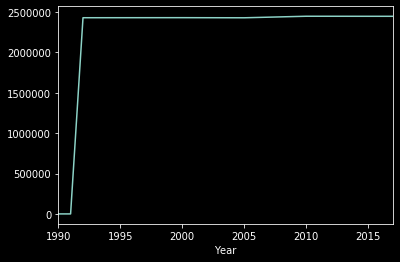

In [170]:
# we can truly observe that there is an inconsistency in the data
forested_area_yearly.loc["Russian Federation"].plot()


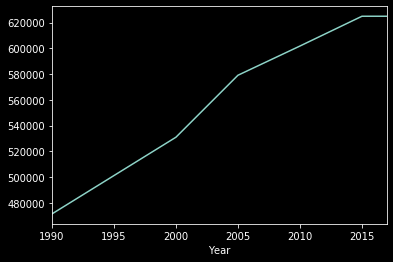

In [171]:
# China, mainland seem to have an increasing areas of forest over the time
forested_area_yearly.loc["China:mainland"].plot()

### Environment_LandUse_E_All_Data_cleared.csv

In [188]:
# load ENV LansUse and select share of the forests in the each Area per yesr 
ENV_LAND_USE_FOREST = ['Forest land', 'Primary Forest', 'Planted Forest', 
                       'Other naturally regenerated forest']

env_land_use_all = pd.read_csv("data/faostat/Environment_LandUse_E_All_Data_cleared.csv", engine='python')

env_land_use = env_land_use_all[env_land_use_all.Item.isin(ENV_LAND_USE_FOREST) & env_land_use_all.Element.str.match("Share in Land area")]

env_land_use_yearly = env_land_use.groupby(["Area", "Year"]).Value.sum()
env_land_use_yearly = env_land_use_yearly.unstack("Year").fillna(method="backfill", axis=0)


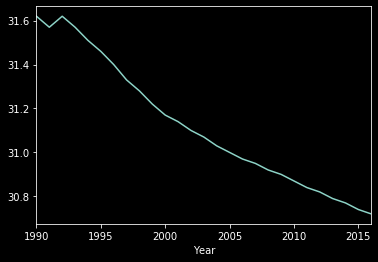

In [192]:
env_land_use_yearly.loc['World'].plot()


In [190]:
env_land_use_diff = env_land_use_yearly[env_land_use_yearly.index.isin(FAOSTAT_countries)].iloc[:, 0] -                           env_land_use_yearly[env_land_use_yearly.index.isin(FAOSTAT_countries)].iloc[:, -1]

env_land_use_diff = env_land_use_diff.sort_values(ascending=False)


In [193]:
# the top 20 countries which have deforestated by % of deforestated areas
env_land_use_diff[:20]


Area
Honduras                                 32.74
Democratic People's Republic of Korea    27.38
Zimbabwe                                 21.75
Cambodia                                 20.48
Timor-Leste                              19.58
United States Virgin Islands             17.40
Myanmar                                  16.38
Indonesia                                15.58
Paraguay                                 15.50
Uganda                                   14.10
Mayotte                                  13.48
Benin                                    13.30
Cameroon                                 12.10
Nigeria                                  11.69
Nicaragua                                11.63
Guatemala                                11.61
United Republic of Tanzania              11.55
Belize                                   11.17
Equatorial Guinea                        10.82
Niue                                     10.00
dtype: float64

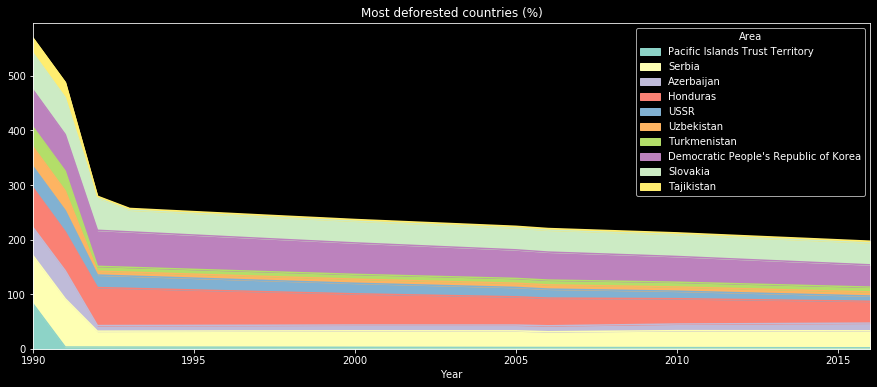

In [186]:
env_land_use_yearly.loc[env_land_use_diff[:10].index].T.plot.area(figsize=(15,6), title="Most deforested countries (%)")


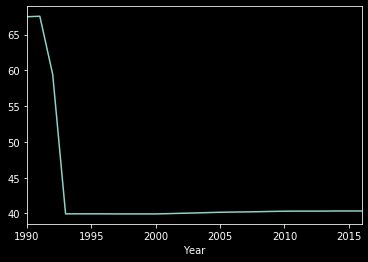

In [187]:
# develoment of forests in Slovakia (%)
env_land_use_yearly.loc["Slovakia"].plot()

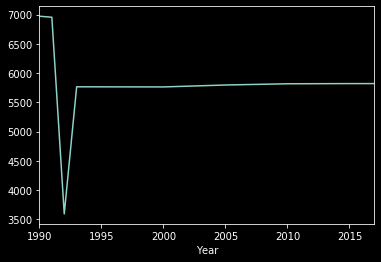

In [202]:
# develoment of forests in Slovakia (square area)
forested_area_yearly.loc["Slovakia"].plot()


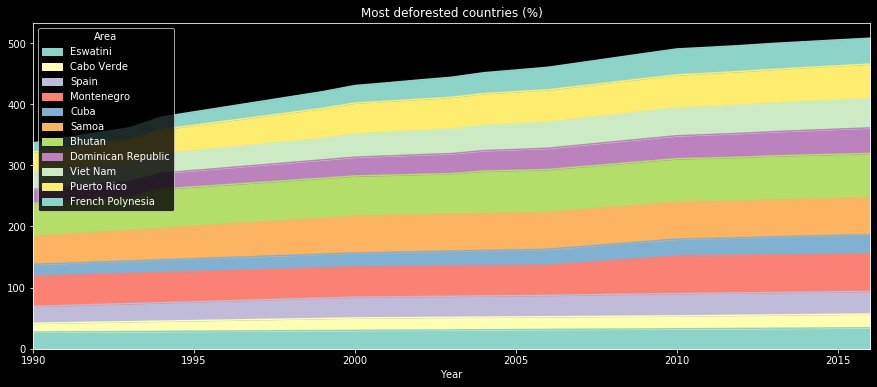

In [201]:
env_land_use_yearly.loc[env_land_use_diff[-20:-9].index].T.plot.area(figsize=(15,6), title="Less deforested countries (%)")


### Environment_LandCover_E_All_Data_cleared.csv

In [132]:
# load ENV landConver and select tree covered ares (per country per year) and split them by origin
env_land_cover_all = pd.read_csv("data/faostat/Environment_LandCover_E_All_Data_cleared.csv", engine='python')

env_land_cover_MODIS = env_land_cover_all[env_land_cover_all.Item.str.match("Tree-covered areas") &                                                     env_land_cover_all.Element.str.match("Area from MODIS")]\
                                         .groupby(["Area", "Year"])\
                                         .Value.sum()\
                                         .unstack("Year")\
                                         .fillna(method="backfill")

env_land_cover_CCI_LC = env_land_cover_all[env_land_cover_all.Item.str.match("Tree-covered areas") &                                                     env_land_cover_all.Element.str.match("Area from CCI_LC")]\
                                          .groupby(["Area", "Year"])\
                                          .Value.sum()\
                                          .unstack("Year")\
                                          .fillna(method="backfill")


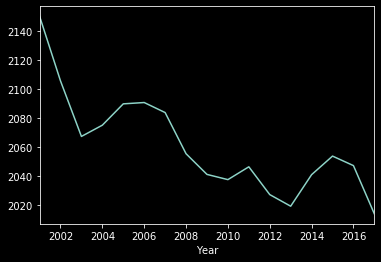

In [130]:
# plot forest are in Switzerland per year base on the MODIS data
env_land_cover_MODIS.loc["Switzerland"].plot()


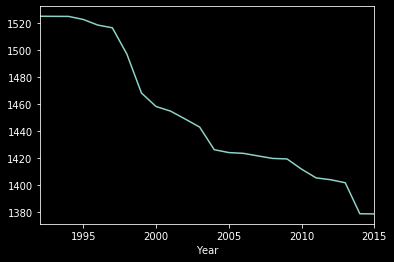

In [135]:
# plot forest are in Switzerland per year base on the CCI_LC data
env_land_cover_CCI_LC.loc["Switzerland"].plot()


#### Note to the CCI_LC & MODIS
**MODIS** data are only from the year 2001, they seem to differ from the **CCI_LC** data.


## The wood trade
Later we've started to look for the biggest producers and consumers of the wood in the world.

In [205]:
# load Forestry data
forest_all = pd.read_csv("data/faostat/Forestry_E_All_Data_cleared.csv", engine='python')
forest_trade = pd.read_csv("data/faostat/Forestry_Trade_Flows_E_All_Data_cleared.csv", engine='python')


In [210]:
# the wood production of countries in m3
wood_production_m3 = forest_all[forest_all.Element.str.match("Production") & 
                                forest_all.Area.isin(FAOSTAT_countries) & 
                                forest_all.Unit.str.match("m3")]\
                                .groupby(["Area", "Year"])\
                                .Value.sum().unstack("Year")


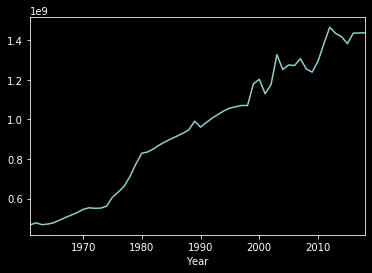

In [211]:
# the wood production of Brazil in m3
wood_production_m3.loc["Brazil"].plot()

In [212]:
# the biggest producer of wood in 2018
wood_production_m3.loc[:, 2018].sort_values(ascending=False).head(20)


Area
United States of America            2.862400e+09
China:mainland                      2.546835e+09
Russian Federation                  1.589406e+09
India                               1.534867e+09
Brazil                              1.436541e+09
Canada                              1.137304e+09
Indonesia                           6.445435e+08
Sweden                              5.032570e+08
Germany                             5.022776e+08
Ethiopia                            4.603311e+08
Finland                             4.588330e+08
Chile                               3.923023e+08
Democratic Republic of the Congo    3.662536e+08
Poland                              3.358665e+08
Nigeria                             3.278924e+08
France                              3.142304e+08
Australia                           2.710942e+08
Viet Nam                            2.454429e+08
Japan                               2.147920e+08
Mexico                              2.122413e+08
Name: 2018, dty

In [213]:
# wood export of countries per year in m3
wood_export_m3 = forest_all[forest_all.Element.str.match("Export Quantity") & 
                            forest_all.Unit.str.match("m3") & 
                            forest_all.Area.isin(FAOSTAT_countries)]\
                           .groupby(["Area", "Year"])\
                           .Value.sum()\
                           .unstack("Year")


In [218]:
wood_export_tonnes = forest_all[forest_all.Element.str.match("Export Quantity") & 
                                forest_all.Unit.str.match("tonnes") & 
                                forest_all.Area.isin(FAOSTAT_countries)]\
                                .groupby(["Area", "Year"])\
                                .Value.sum()\
                                .unstack("Year")


In [219]:
wood_export_m3.loc[:, 2018].sort_values(ascending=False).head(10)


Area
Russian Federation          159085467.0
Canada                      108484104.0
New Zealand                 100992260.0
United States of America     83218571.0
Germany                      60288070.0
Australia                    46625726.0
Czechia                      35948676.0
Poland                       33188613.0
Viet Nam                     31409440.0
France                       29555247.0
Name: 2018, dtype: float64

In [221]:
wood_export_tonnes.loc[:, 2018].sort_values(ascending=False).head(10)


Area
United States of America    160562185.0
Canada                       98102389.0
Brazil                       92900134.0
Germany                      90893070.0
Finland                      77437050.0
Sweden                       71448776.0
Indonesia                    49749723.0
China:mainland               33079734.0
Russian Federation           32694767.0
Chile                        29571144.0
Name: 2018, dtype: float64

## Is agricultural industry influencing deforestation? 
One of the most negative influences on the deforestation might have an agricultural industry. We've decided to investigate this possible connection.

In [ ]:
#TODO

## Is breeding farm animals influencing deforestation? 
Breeding animals might be space consumig, we've searched for the origin of the land used for this purpose.


In [ ]:
#TODO